# Voiceprint Verification using Logistic Regression
## Task 4: Model Creation

This notebook implements a voiceprint verification system using Logistic Regression classifier on audio features.

In [1]:
# Import necessary libraries
import matplotlib
import pandas as pd
import joblib
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, log_loss
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Joblib version: {joblib.__version__}")

All libraries imported successfully!
Pandas version: 2.0.3
NumPy version: 1.24.3
Scikit-learn version: 1.3.0
Matplotlib version: 3.10.3
Seaborn version: 0.13.2
Joblib version: 1.3.2


In [2]:
# Set up paths
NOTEBOOK_DIR = Path.cwd()
ROOT_DIR = NOTEBOOK_DIR.parent

# Data paths
AUDIO_FEATURES_PATH = ROOT_DIR / "Audio_Processing" / "audio_features.csv"

print(f"Notebook Directory: {NOTEBOOK_DIR}")
print(f"Root Directory: {ROOT_DIR}")
print(f"Audio Features Path: {AUDIO_FEATURES_PATH}")

Notebook Directory: c:\Users\Hello\OneDrive\Documents\Formative-2__Data-Preprocessing\model_notebook
Root Directory: c:\Users\Hello\OneDrive\Documents\Formative-2__Data-Preprocessing
Audio Features Path: c:\Users\Hello\OneDrive\Documents\Formative-2__Data-Preprocessing\Audio_Processing\audio_features.csv


# 1. Data Loading and Initial Exploration

In [3]:
# Load the dataset
df = pd.read_csv(AUDIO_FEATURES_PATH)

# Display basic information
print(" Dataset loaded successfully!")
print("\nDataset Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head(5))

print("\nDataset Info:")
df.info()

 Dataset loaded successfully!

Dataset Shape: (104, 56)

First 5 rows:


,member,phrase,augmentation,timestamp,sample_rate,duration,mfcc_0,mfcc_1,mfcc_2,mfcc_3,...,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_contrast_mean,spectral_contrast_std
0,Erneste,yes_approve,Original,2025-11-13 16:37:27,48000,2.944000,-544.000244,64.125717,-7.260704,10.644255,...,0.367683,0.393029,0.439834,0.502428,0.497949,0.398780,3228.417077,2553.376981,17.918020,8.220902
1,Erneste,yes_approve,Pitch_Shift_+2st,2025-11-13 16:37:27,48000,2.944000,-576.934875,62.546635,-9.947507,11.298633,...,0.477169,0.373771,0.375039,0.398981,0.439535,0.511343,3216.232992,2307.075015,21.376739,12.460734
2,Erneste,yes_approve,Pitch_Shift_-2st,2025-11-13 16:37:27,48000,2.944000,-575.393311,66.931969,-4.755910,9.647106,...,0.462035,0.521491,0.475377,0.399761,0.354755,0.322518,2790.748985,2099.793305,20.752129,13.810715
3,Erneste,yes_approve,Time_Stretch_1.2x,2025-11-13 16:37:27,48000,2.453333,-601.064758,72.333031,-10.830731,11.885284,...,0.342736,0.402432,0.443587,0.486758,0.480624,0.381098,3216.452658,2458.959994,17.791945,7.808880
4,Erneste,yes_approve,Time_Stretch_0.8x,2025-11-13 16:37:27,48000,3.680000,-598.373718,69.994415,-9.865419,11.541083,...,0.337669,0.363237,0.416676,0.493560,0.480065,0.386136,3257.759926,2498.172732,18.328079,8.018894



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 56 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   member                   104 non-null    object 
 1   phrase                   104 non-null    object 
 2   augmentation             104 non-null    object 
 3   timestamp                104 non-null    object 
 4   sample_rate              104 non-null    int64  
 5   duration                 104 non-null    float64
 6   mfcc_0                   104 non-null    float64
 7   mfcc_1                   104 non-null    float64
 8   mfcc_2                   104 non-null    float64
 9   mfcc_3                   104 non-null    float64
 10  mfcc_4                   104 non-null    float64
 11  mfcc_5                   104 non-null    float64
 12  mfcc_6                   104 non-null    float64
 13  mfcc_7                   104 non-null    float64
 14  mfcc_8     

In [4]:
# Summary statistics
print("Summary Statistics:")
display(df.describe())

# Check for missing values
print("\nMissing Values Analysis:")
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100
missing_info = pd.DataFrame({'Missing Count': missing_data, 'Percentage': missing_percentage})
display(missing_info[missing_info['Missing Count'] > 0])

# Check target variable distribution
target_col = 'member'  # Using 'member' as the target for speaker identification
    
print(f"\nTarget variable: {target_col}")
print(f"Number of unique speakers: {df[target_col].nunique()}")
print(f"Speaker distribution:\n{df[target_col].value_counts()}")
print(f"\nPhrase distribution:\n{df['phrase'].value_counts()}")
print(f"\nAugmentation distribution:\n{df['augmentation'].value_counts()}")

# Check variable types
print("\nVariable Types:")
print(f"Numeric columns: {len(df.select_dtypes(include=[np.number]).columns)}")
print(f"Categorical columns: {len(df.select_dtypes(include=['object']).columns)}")
print(f"Total features: {len(df.columns)}")

Summary Statistics:


,sample_rate,duration,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_contrast_mean,spectral_contrast_std
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,...,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,47025.000000,2.939871,-467.246277,76.586024,2.353149,12.226331,2.717782,2.185513,3.486761,-3.923649,...,0.433687,0.443970,0.483039,0.514911,0.538526,0.479184,4274.547699,1805.956583,18.027429,9.201738
std,1696.927549,0.426600,80.200569,27.393427,17.546999,8.179578,3.283395,8.680049,3.476573,5.646587,...,0.120948,0.112026,0.109256,0.088337,0.127037,0.100110,1542.717520,498.770840,2.552738,3.101893
min,44100.000000,1.991104,-602.224304,10.103230,-29.137581,-1.467185,-5.297270,-14.120597,-3.532387,-18.885080,...,0.212613,0.248450,0.248448,0.250603,0.300398,0.311100,2079.288183,420.540112,12.331712,4.478440
25%,47025.000000,2.794667,-530.713318,61.135736,-12.766898,5.690991,0.619800,-3.054836,0.987391,-7.705109,...,0.314905,0.347268,0.413466,0.460267,0.468618,0.402969,2789.731199,1553.648153,16.362730,7.448278
50%,48000.000000,2.837333,-471.264786,71.892357,4.782751,10.552864,2.205562,1.804570,2.896627,-1.751051,...,0.437646,0.439380,0.455570,0.507541,0.504762,0.481870,3654.030180,1854.983873,18.324816,8.280937
75%,48000.000000,3.080000,-403.044105,98.843819,20.641136,17.826420,4.599815,10.141137,5.252975,-0.744368,...,0.517578,0.533041,0.550793,0.553769,0.612258,0.531926,5666.478179,2214.739035,19.498449,9.616848
max,48000.000000,4.585941,-275.834163,128.766998,27.896132,28.215317,10.392493,14.780191,11.642331,10.513144,...,0.718621,0.680964,0.855691,0.725235,0.833067,0.791610,7097.772082,2553.376981,23.231140,17.123946



Missing Values Analysis:


,Missing Count,Percentage



Target variable: member
Number of unique speakers: 4
Speaker distribution:
member
Erneste    26
Thierry    26
Rodas      26
Idara      26
Name: count, dtype: int64

Phrase distribution:
phrase
yes_approve            52
confirm_transaction    52
Name: count, dtype: int64

Augmentation distribution:
augmentation
Original                   8
Pitch_Shift_+2st           8
Pitch_Shift_-2st           8
Time_Stretch_1.2x          8
Time_Stretch_0.8x          8
Background_Noise_Low       8
Background_Noise_Medium    8
Volume_Increase_1.5x       8
Volume_Decrease_0.7x       8
Pitch_Shift_+1st           8
Time_Stretch_1.1x          8
Reverse_Audio              8
Echo_Effect                8
Name: count, dtype: int64

Variable Types:
Numeric columns: 52
Categorical columns: 4
Total features: 56


# 2. Exploratory Data Analysis (EDA)

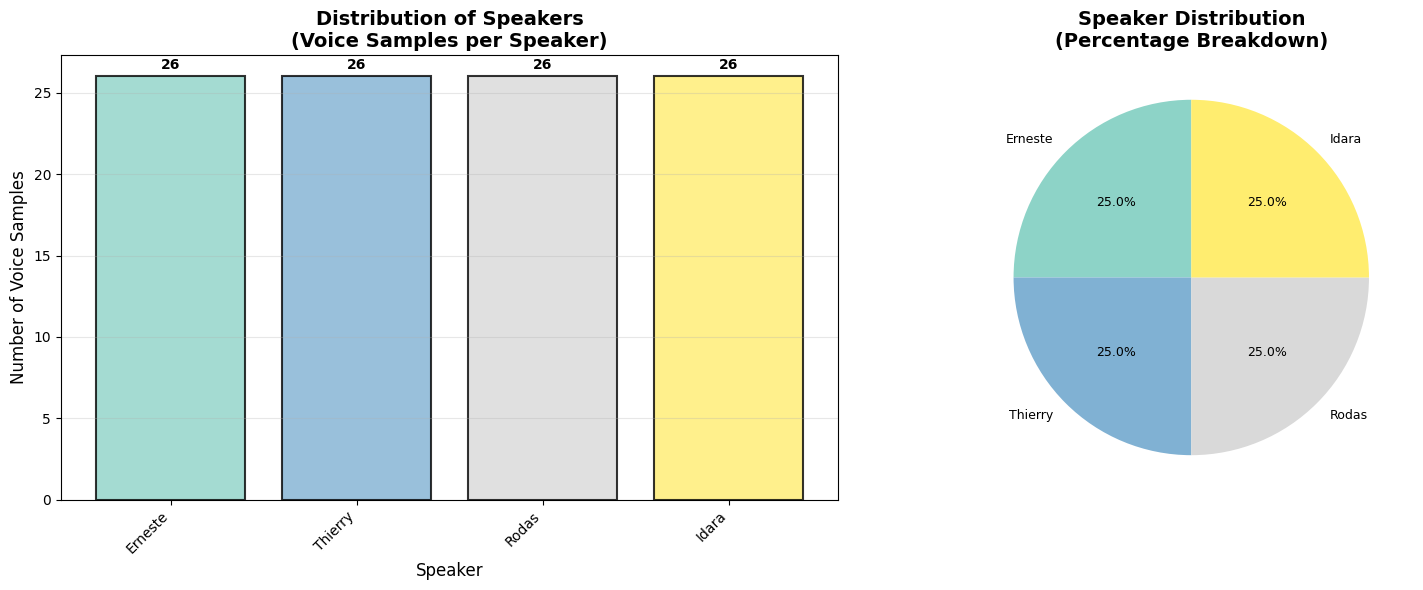


Data Balance Analysis:
Majority speaker: Erneste with 26 samples
Minority speaker: Erneste with 26 samples
Balance ratio: 1.00x (Balanced)


In [5]:
# Plot 1: Distribution of Speakers with enhanced visualization
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
speaker_counts = df[target_col].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(speaker_counts)))
bars = plt.bar(range(len(speaker_counts)), speaker_counts.values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
plt.title('Distribution of Speakers\n(Voice Samples per Speaker)', fontsize=14, fontweight='bold')
plt.xlabel('Speaker', fontsize=12)
plt.ylabel('Number of Voice Samples', fontsize=12)
plt.xticks(range(len(speaker_counts)), speaker_counts.index, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, speaker_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(speaker_counts.values)*0.01, 
             str(count), ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.subplot(1, 2, 2)
plt.pie(speaker_counts.values, labels=speaker_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=colors, textprops={'fontsize': 9})
plt.title('Speaker Distribution\n(Percentage Breakdown)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Data balance analysis
balance_ratio = speaker_counts.max() / speaker_counts.min()
print(f"\nData Balance Analysis:")
print(f"Majority speaker: {speaker_counts.idxmax()} with {speaker_counts.max()} samples")
print(f"Minority speaker: {speaker_counts.idxmin()} with {speaker_counts.min()} samples")
print(f"Balance ratio: {balance_ratio:.2f}x ({'Balanced' if balance_ratio < 3 else 'Moderately Imbalanced' if balance_ratio < 5 else 'Highly Imbalanced'})")

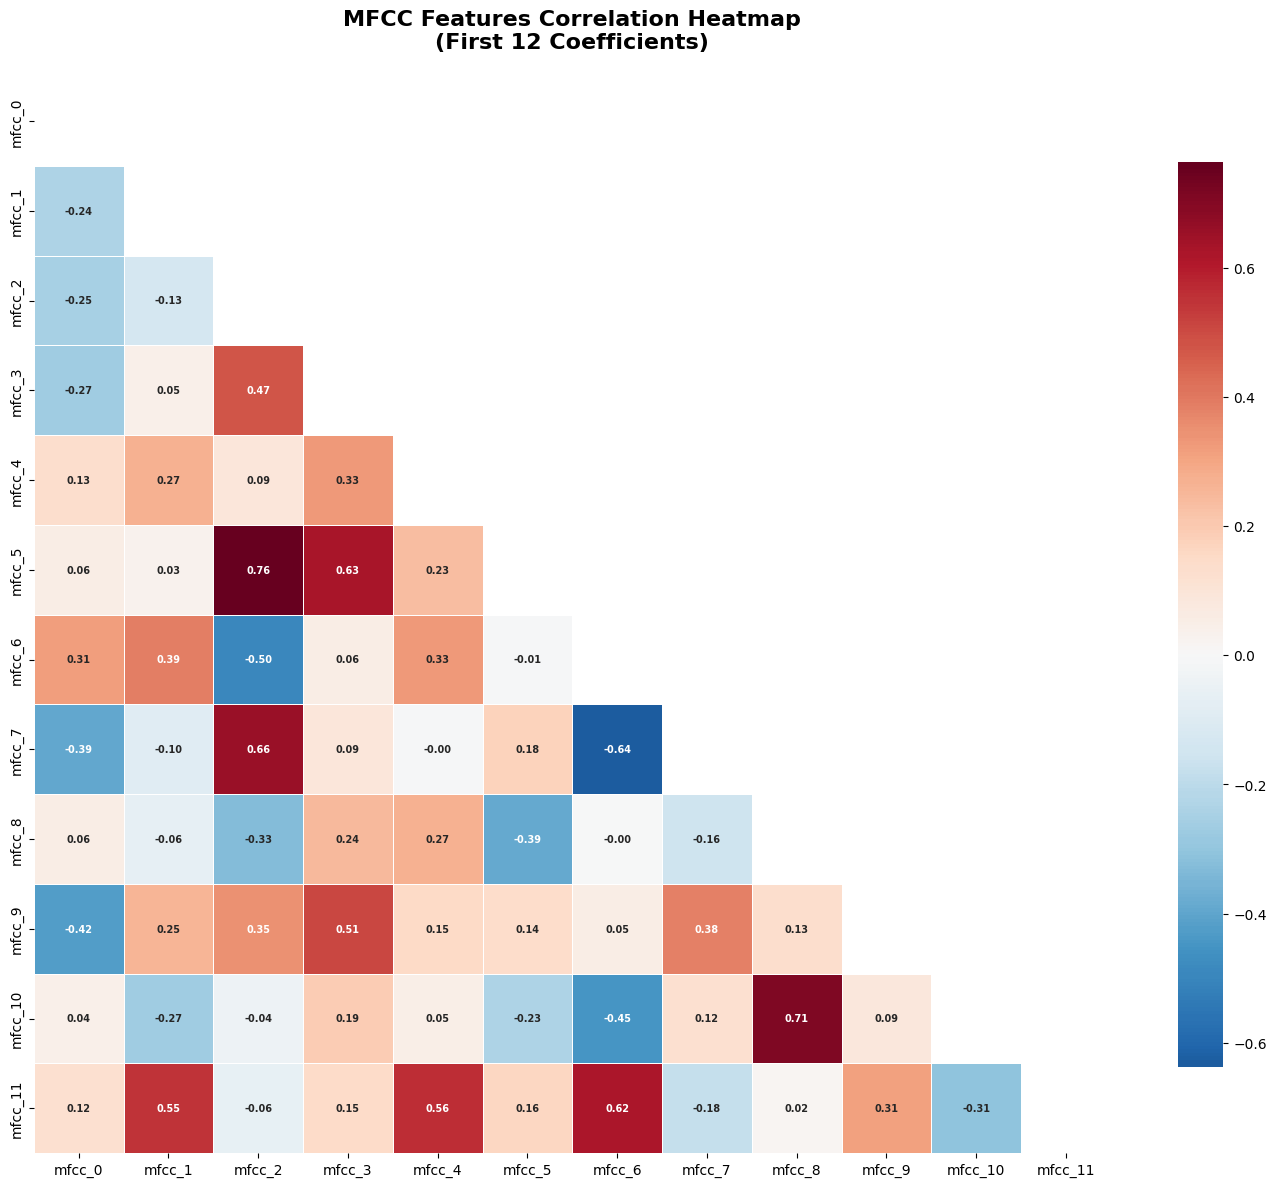


Correlation Insights:
Highly correlated MFCC pairs (|r| > 0.7):
  mfcc_2 - mfcc_5: 0.763
  mfcc_8 - mfcc_10: 0.709


In [6]:
# Plot 2: Feature Correlations Heatmap with enhanced insights
mfcc_cols = [col for col in df.columns if col.startswith('mfcc_') and not col.startswith('mfcc_std')]
mfcc_cols = mfcc_cols[:12]  # Take first 12 MFCC coefficients

plt.figure(figsize=(14, 12))
correlation_matrix = df[mfcc_cols].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f',
            annot_kws={'size': 7, 'weight': 'bold'})
plt.title('MFCC Features Correlation Heatmap\n(First 12 Coefficients)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Correlation insights
print("\nCorrelation Insights:")
high_corr_pairs = []
for i in range(len(mfcc_cols)):
    for j in range(i+1, len(mfcc_cols)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((mfcc_cols[i], mfcc_cols[j], corr_val))

if high_corr_pairs:
    print("Highly correlated MFCC pairs (|r| > 0.7):")
    for pair in high_corr_pairs[:5]:  # Show top 5
        print(f"  {pair[0]} - {pair[1]}: {pair[2]:.3f}")
else:
    print("No highly correlated MFCC pairs found (all |r| < 0.7)")

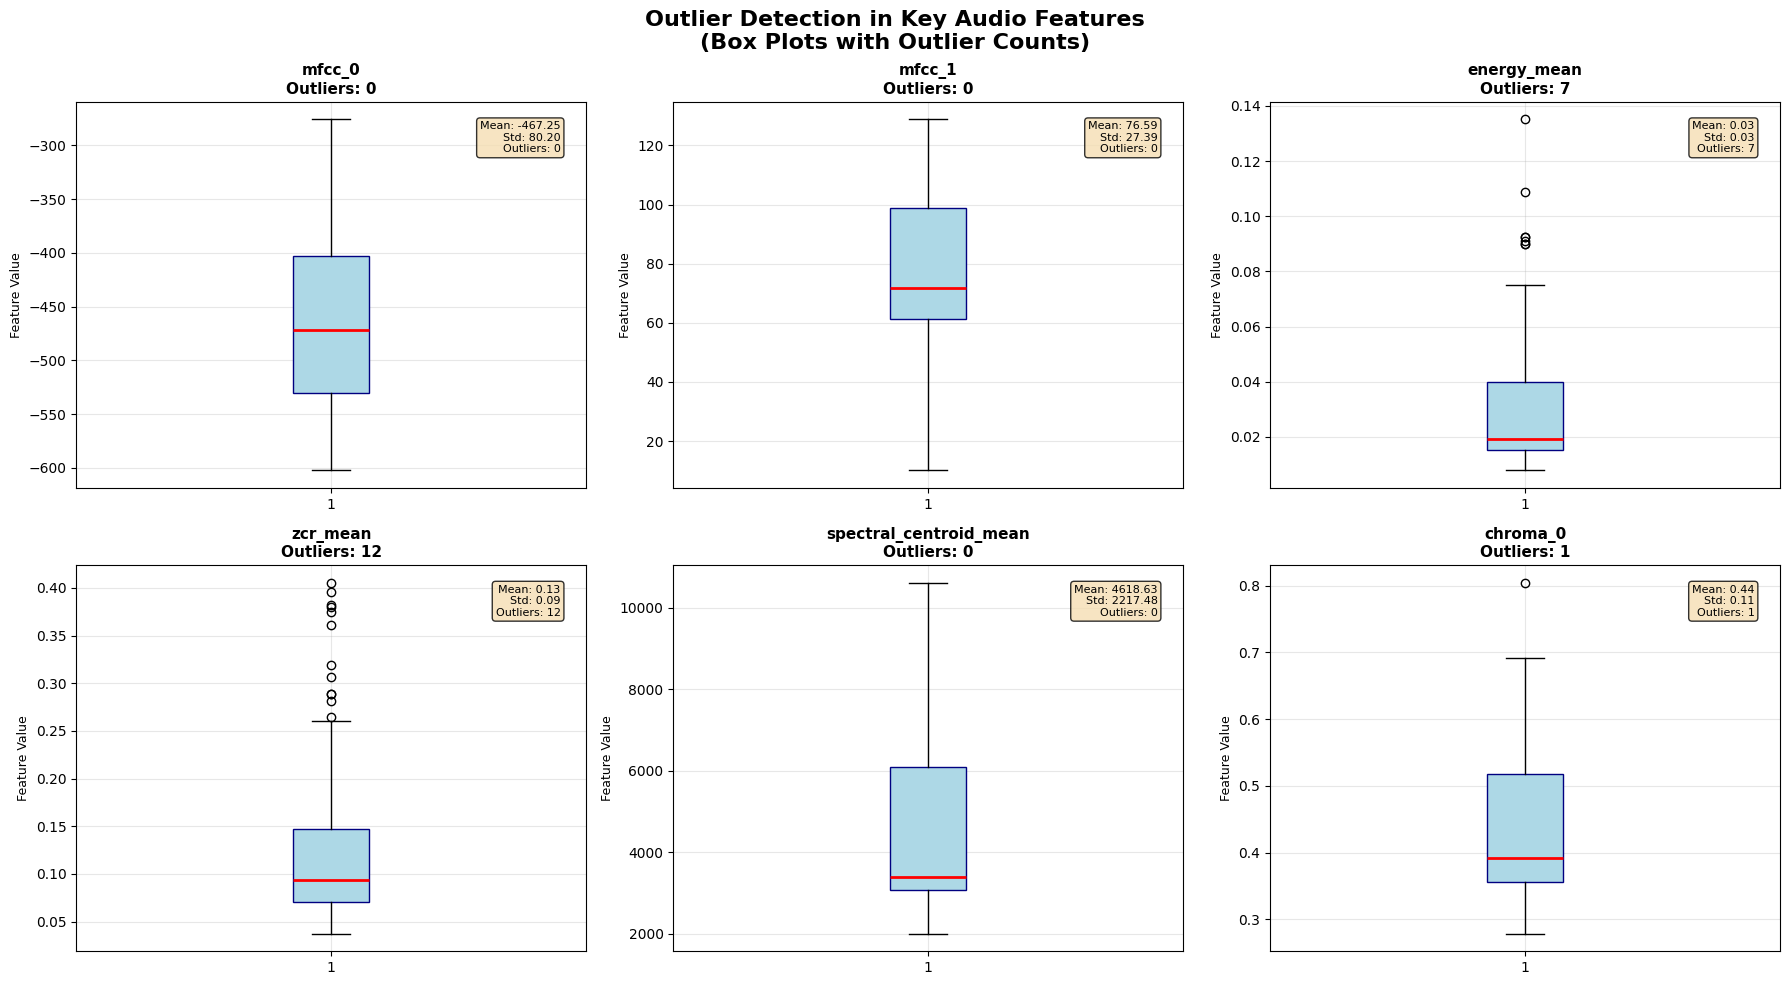


Outlier Summary for Key Features:
  mfcc_0: 0 outliers (0.0%)
  mfcc_1: 0 outliers (0.0%)
  energy_mean: 7 outliers (6.7%)
  zcr_mean: 12 outliers (11.5%)
  spectral_centroid_mean: 0 outliers (0.0%)
  chroma_0: 1 outliers (1.0%)

Total outliers across key features: 20
Average outlier percentage: 3.2%


In [7]:
# Plot 3: Outlier Detection using Box Plots for key audio features
key_features = ['mfcc_0', 'mfcc_1', 'energy_mean', 'zcr_mean', 'spectral_centroid_mean', 'chroma_0']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    # Create boxplot
    boxplot = axes[i].boxplot(df[feature], vert=True, patch_artist=True, 
                            boxprops=dict(facecolor='lightblue', color='navy'),
                            medianprops=dict(color='red', linewidth=2))
    
    # Calculate outlier statistics
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    
    axes[i].set_title(f'{feature}\nOutliers: {len(outliers)}', fontweight='bold', fontsize=11)
    axes[i].set_ylabel('Feature Value', fontsize=9)
    axes[i].grid(True, alpha=0.3)
    
    # Add statistical info
    stats_text = f'Mean: {df[feature].mean():.2f}\nStd: {df[feature].std():.2f}\nOutliers: {len(outliers)}'
    axes[i].text(0.95, 0.95, stats_text, transform=axes[i].transAxes, 
                fontsize=8, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle('Outlier Detection in Key Audio Features\n(Box Plots with Outlier Counts)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Overall outlier summary
print("\nOutlier Summary for Key Features:")
total_outliers = 0
for feature in key_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[feature] < Q1 - 1.5 * IQR) | (df[feature] > Q3 + 1.5 * IQR)]
    total_outliers += len(outliers)
    print(f"  {feature}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.1f}%)")

print(f"\nTotal outliers across key features: {total_outliers}")
print(f"Average outlier percentage: {total_outliers/(len(key_features)*len(df))*100:.1f}%")

# 3. Data Preprocessing

In [8]:
# Prepare features and target
# Select only numerical features for modeling
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove non-feature columns
non_feature_cols = ['sample_rate', 'duration']
numerical_cols = [col for col in numerical_cols if col not in non_feature_cols]

X = df[numerical_cols]
y = df[target_col]

print(f"Original number of features: {X.shape[1]}")

# Handle missing values
missing_before = X.isnull().sum().sum()
if missing_before > 0:
    X = X.fillna(X.median())
    missing_after = X.isnull().sum().sum()
    print(f"Missing values handled: {missing_before} -> {missing_after}")

# Feature Selection for high-dimensional data
if X.shape[1] > 50:
    print(f"\nPerforming feature selection...")
    selector = SelectKBest(score_func=f_classif, k=min(50, X.shape[1]))
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()]
    X = pd.DataFrame(X_selected, columns=selected_features, index=X.index)
    print(f"After feature selection: {X.shape[1]} features")

# Scale features using RobustScaler (better for audio features with outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nFinal dataset shape:")
print(f"Feature matrix: {X_scaled.shape}")
print(f"Target vector: {y_encoded.shape}")
print(f"Number of speakers: {len(np.unique(y_encoded))}")
print(f"Speaker distribution: {dict(zip(le.classes_, np.bincount(y_encoded)))}")

Original number of features: 50

Final dataset shape:
Feature matrix: (104, 50)
Target vector: (104,)
Number of speakers: 4
Speaker distribution: {'Erneste': 26, 'Idara': 26, 'Rodas': 26, 'Thierry': 26}


# 4. Model Training - Logistic Regression

In [9]:
# Check class distribution and handle small classes
class_counts = np.bincount(y_encoded)
print("Class distribution before splitting:", class_counts)

# Identify classes with insufficient samples
min_samples_per_class = 2  # Minimum needed for stratification
small_classes = np.where(class_counts < min_samples_per_class)[0]

if len(small_classes) > 0:
    print(f"Warning: Classes {[le.classes_[c] for c in small_classes]} have insufficient samples for stratification")
    print("Using regular train_test_split without stratification...")
    
    # Split without stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=None
    )
else:
    # Split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

print("\n=== Data Split Summary ===")
print(f"Training set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Number of features: {X_train.shape[1]}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

Class distribution before splitting: [26 26 26 26]

=== Data Split Summary ===
Training set size: 83 samples (79.8%)
Test set size: 21 samples (20.2%)
Number of features: 50
Training set class distribution: [21 21 20 21]
Test set class distribution: [5 5 6 5]


In [10]:
# Initialize and train Logistic Regression model
lr_model = LogisticRegression(
    C=1.0,  # Regularization strength
    penalty='l2',  # L2 regularization
    solver='liblinear',  # Good for small datasets
    max_iter=1000,  # Increased for convergence
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

print("Training Logistic Regression model...")
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)

print("\nLogistic Regression Model Training Completed!")
print(f"Model coefficients shape: {lr_model.coef_.shape}")
print(f"Model intercept: {lr_model.intercept_[0]:.4f}")
print(f"Number of iterations: {lr_model.n_iter_[0]}")

Training Logistic Regression model...

Logistic Regression Model Training Completed!
Model coefficients shape: (4, 50)
Model intercept: -0.5891
Number of iterations: 6


# 5. Model Evaluation & Multimodal Logic

In [11]:
# Calculate comprehensive metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculate log loss
log_loss_value = log_loss(y_test, y_pred_proba)

# For multi-class, calculate ROC AUC using One-vs-Rest
if len(le.classes_) > 2:
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
else:
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

# Cross-validation scores
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lr_model, X_scaled, y_encoded, cv=cv, scoring='accuracy')

print("=== VOICE PRINT VERIFICATION MODEL EVALUATION ===")
print(f"\n PRIMARY METRICS:")
print(f"   Accuracy: {accuracy:.4f}")
print(f"   F1-Score (weighted): {f1:.4f}")
print(f"   ROC AUC Score: {roc_auc:.4f}")
print(f"   Log Loss: {log_loss_value:.4f}")

print(f"\n CROSS-VALIDATION PERFORMANCE:")
print(f"   Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"   Individual CV scores: {[f'{score:.4f}' for score in cv_scores]}")

# Performance interpretation for voice verification
print(f"\n PERFORMANCE INTERPRETATION:")
if accuracy > 0.95:
    performance_level = "Excellent"
    print(" Excellent performance for voice verification")
elif accuracy > 0.90:
    performance_level = "Very Good"
    print(" Very good performance")
elif accuracy > 0.85:
    performance_level = "Good"
    print(" Good performance")
elif accuracy > 0.80:
    performance_level = "Moderate"
    print(" Moderate performance - consider feature engineering")
else:
    performance_level = "Needs Improvement"
    print(" Needs improvement - review features and model parameters")

=== VOICE PRINT VERIFICATION MODEL EVALUATION ===

 PRIMARY METRICS:
   Accuracy: 1.0000
   F1-Score (weighted): 1.0000
   ROC AUC Score: 1.0000
   Log Loss: 0.1090

 CROSS-VALIDATION PERFORMANCE:
   Mean CV Accuracy: 1.0000 (+/- 0.0000)
   Individual CV scores: ['1.0000', '1.0000', '1.0000', '1.0000', '1.0000']

 PERFORMANCE INTERPRETATION:
 Excellent performance for voice verification


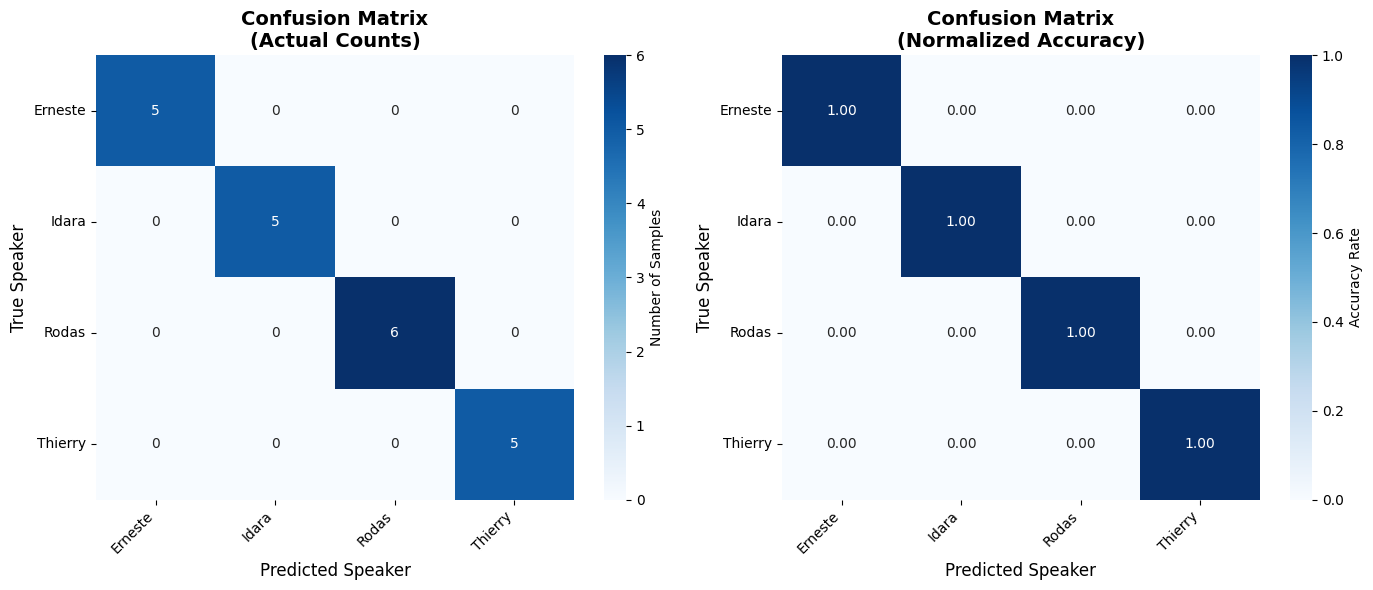


 PER-CLASS PERFORMANCE ANALYSIS:
   ✅ Speaker Erneste: 1.000 accuracy
   ✅ Speaker Idara: 1.000 accuracy
   ✅ Speaker Rodas: 1.000 accuracy
   ✅ Speaker Thierry: 1.000 accuracy

Overall Classification Metrics:
   Average per-class accuracy: 1.000
   Minimum class accuracy: 1.000
   Maximum class accuracy: 1.000


In [12]:
# Enhanced Confusion Matrix with better visualization
plt.figure(figsize=(14, 6))

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Number of Samples'})
plt.title('Confusion Matrix\n(Actual Counts)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Speaker', fontsize=12)
plt.ylabel('True Speaker', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Accuracy Rate'})
plt.title('Confusion Matrix\n(Normalized Accuracy)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Speaker', fontsize=12)
plt.ylabel('True Speaker', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# Calculate per-class accuracy and performance metrics
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\n PER-CLASS PERFORMANCE ANALYSIS:")
for i, (speaker, acc) in enumerate(zip(le.classes_, class_accuracy)):
    performance_indicator = "✅" if acc > 0.85 else "🟡" if acc > 0.70 else "🔴"
    print(f"   {performance_indicator} Speaker {speaker}: {acc:.3f} accuracy")

# Overall classification metrics
print(f"\nOverall Classification Metrics:")
print(f"   Average per-class accuracy: {np.mean(class_accuracy):.3f}")
print(f"   Minimum class accuracy: {np.min(class_accuracy):.3f}")
print(f"   Maximum class accuracy: {np.max(class_accuracy):.3f}")

In [13]:
# Detailed classification report with enhanced formatting
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=3))

# Model confidence analysis
print("\n MODEL CONFIDENCE ANALYSIS:")
max_probs = np.max(y_pred_proba, axis=1)
confidence_thresholds = [0.9, 0.8, 0.7, 0.6]
print("   Prediction confidence distribution:")
for threshold in confidence_thresholds:
    count = np.sum(max_probs >= threshold)
    percentage = count / len(max_probs) * 100
    print(f"     • {threshold:.1f}+ confidence: {count} predictions ({percentage:.1f}%)")

# Calculate prediction stability
correct_high_confidence = np.sum((max_probs >= 0.8) & (y_pred == y_test))
high_confidence_accuracy = correct_high_confidence / np.sum(max_probs >= 0.8) if np.sum(max_probs >= 0.8) > 0 else 0
print(f"\n   High-confidence (≥0.8) accuracy: {high_confidence_accuracy:.3f}")


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Erneste      1.000     1.000     1.000         5
       Idara      1.000     1.000     1.000         5
       Rodas      1.000     1.000     1.000         6
     Thierry      1.000     1.000     1.000         5

    accuracy                          1.000        21
   macro avg      1.000     1.000     1.000        21
weighted avg      1.000     1.000     1.000        21


 MODEL CONFIDENCE ANALYSIS:
   Prediction confidence distribution:
     • 0.9+ confidence: 14 predictions (66.7%)
     • 0.8+ confidence: 18 predictions (85.7%)
     • 0.7+ confidence: 20 predictions (95.2%)
     • 0.6+ confidence: 21 predictions (100.0%)

   High-confidence (≥0.8) accuracy: 1.000


# 6. Feature Importance Analysis

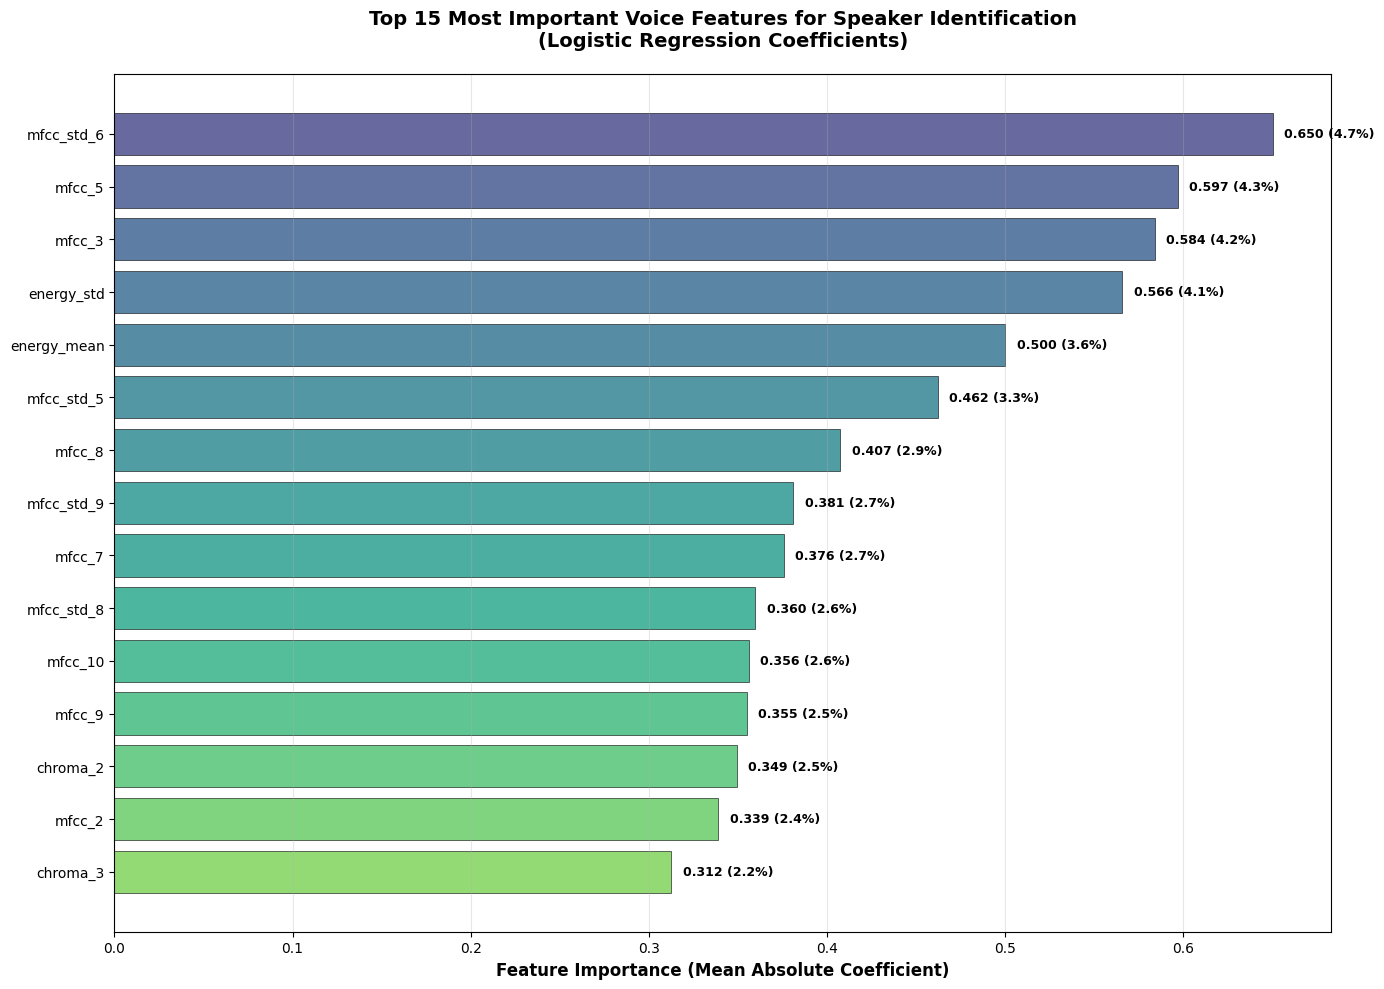


🔝 TOP 10 MOST IMPORTANT FEATURES:


,feature,importance,importance_normalized
19,mfcc_std_6,0.650272,0.046577
5,mfcc_5,0.596823,0.042748
3,mfcc_3,0.583970,0.041828
29,energy_std,0.565606,0.040512
28,energy_mean,0.500144,0.035824
18,mfcc_std_5,0.462103,0.033099
8,mfcc_8,0.407293,0.029173
22,mfcc_std_9,0.381073,0.027295
7,mfcc_7,0.375776,0.026916
21,mfcc_std_8,0.359622,0.025759



 FEATURE IMPORTANCE STATISTICS:
   Maximum importance: 0.6503
   Minimum importance: 0.0901
   Mean importance: 0.2792
   Features with importance > 0.1: 49
   Features with importance > 0.05: 50

 CUMULATIVE IMPORTANCE ANALYSIS:
   Top 33 features explain 80% of total importance
   Top 40 features explain 90% of total importance


In [14]:
# Get feature importances from Logistic Regression coefficients
# For multi-class, take mean absolute coefficient across all classes
if len(le.classes_) > 2:
    feature_importance_scores = np.mean(np.abs(lr_model.coef_), axis=0)
else:
    feature_importance_scores = np.abs(lr_model.coef_[0])

feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance_scores,
    'importance_normalized': feature_importance_scores / np.sum(feature_importance_scores)
}).sort_values('importance', ascending=False)

# Plot top 15 most important features with enhanced visualization
plt.figure(figsize=(14, 10))
top_features = feature_importances.head(15)

# Create horizontal bar plot
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_features)))
bars = plt.barh(range(len(top_features)), top_features['importance'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.yticks(range(len(top_features)), top_features['feature'], fontsize=10)
plt.xlabel('Feature Importance (Mean Absolute Coefficient)', fontsize=12, fontweight='bold')
plt.title('Top 15 Most Important Voice Features for Speaker Identification\n(Logistic Regression Coefficients)', 
          fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add value labels and percentage contribution
for i, (bar, importance, norm_imp) in enumerate(zip(bars, top_features['importance'], top_features['importance_normalized'])):
    plt.text(bar.get_width() + max(top_features['importance']) * 0.01, 
             bar.get_y() + bar.get_height()/2, 
             f'{importance:.3f} ({norm_imp*100:.1f}%)', 
             ha='left', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("\n🔝 TOP 10 MOST IMPORTANT FEATURES:")
display(top_features.head(10)[['feature', 'importance', 'importance_normalized']])

# Feature importance statistics with insights
print("\n FEATURE IMPORTANCE STATISTICS:")
print(f"   Maximum importance: {feature_importances['importance'].max():.4f}")
print(f"   Minimum importance: {feature_importances['importance'].min():.4f}")
print(f"   Mean importance: {feature_importances['importance'].mean():.4f}")
print(f"   Features with importance > 0.1: {(feature_importances['importance'] > 0.1).sum()}")
print(f"   Features with importance > 0.05: {(feature_importances['importance'] > 0.05).sum()}")

# Cumulative importance analysis
cumulative_importance = feature_importances['importance_normalized'].cumsum()
n_features_80 = np.argmax(cumulative_importance >= 0.8) + 1
n_features_90 = np.argmax(cumulative_importance >= 0.9) + 1
print(f"\n CUMULATIVE IMPORTANCE ANALYSIS:")
print(f"   Top {n_features_80} features explain 80% of total importance")
print(f"   Top {n_features_90} features explain 90% of total importance")

# 7. Model Performance Visualization

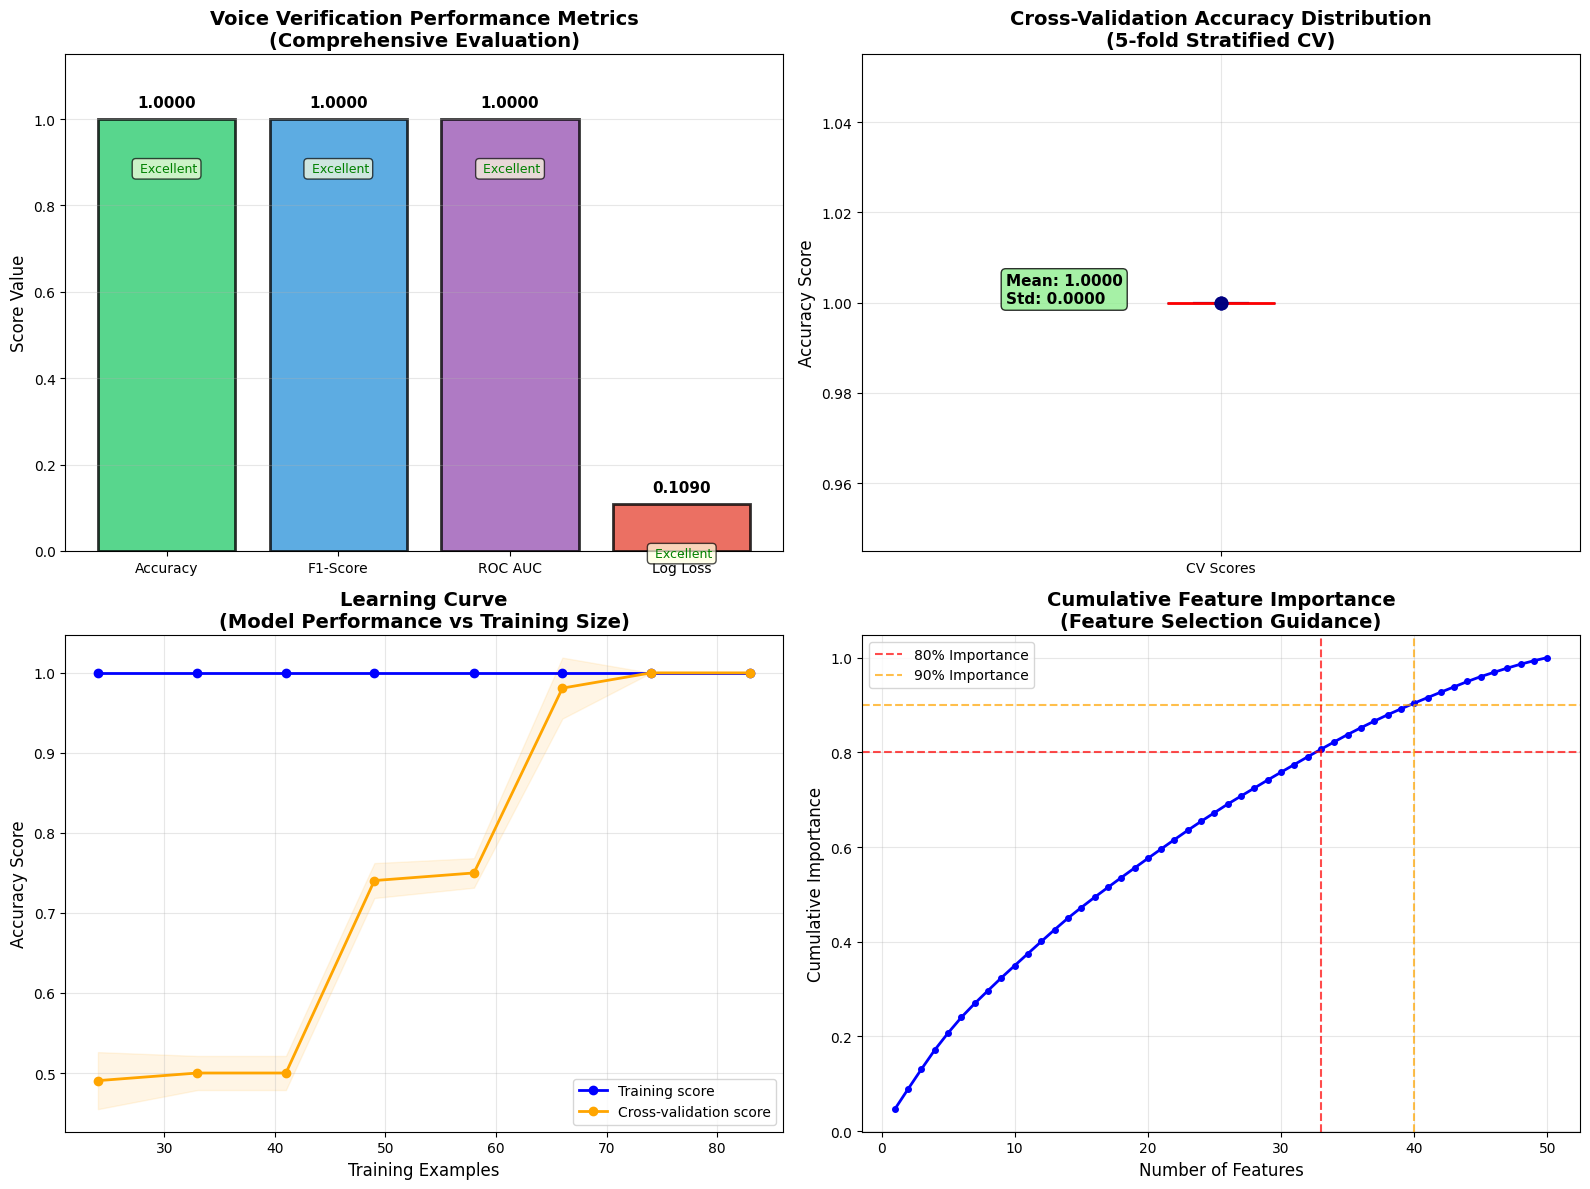

In [15]:
# Comprehensive Performance Metrics Visualization
metrics = ['Accuracy', 'F1-Score', 'ROC AUC', 'Log Loss']
values = [accuracy, f1, roc_auc, log_loss_value]
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Bar chart for main metrics
bars = ax1.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_title('Voice Verification Performance Metrics\n(Comprehensive Evaluation)', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('Score Value', fontsize=12)
ax1.set_ylim(0, max(values[:3]) * 1.15)  # Exclude log loss from max calculation
ax1.grid(axis='y', alpha=0.3)

# Add value labels with performance indicators
for i, (bar, value, metric) in enumerate(zip(bars, values, metrics)):
    height = bar.get_height()
    if metric != 'Log Loss':
        # For accuracy metrics (higher is better)
        if value > 0.9:
            color = 'green'
            indicator = ' Excellent'
        elif value > 0.8:
            color = 'orange'
            indicator = ' Good'
        else:
            color = 'red'
            indicator = ' Needs Work'
    else:
        # For log loss (lower is better)
        if value < 0.3:
            color = 'green'
            indicator = ' Excellent'
        elif value < 0.5:
            color = 'orange'
            indicator = ' Good'
        else:
            color = 'red'
            indicator = ' Needs Work'
    
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.02, 
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    ax1.text(bar.get_x() + bar.get_width()/2, height - max(values[:3]) * 0.1, 
             indicator, ha='center', va='top', fontsize=9, color=color,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.7))

# Cross-validation scores distribution
ax2.boxplot(cv_scores, vert=True, patch_artist=True, 
           boxprops=dict(facecolor='lightblue', color='navy'),
           medianprops=dict(color='red', linewidth=2),
           whiskerprops=dict(color='navy', linewidth=1.5),
           capprops=dict(color='navy', linewidth=1.5))
ax2.scatter(np.ones_like(cv_scores), cv_scores, alpha=0.6, color='navy', s=80, zorder=3)
ax2.set_title('Cross-Validation Accuracy Distribution\n(5-fold Stratified CV)', 
              fontsize=14, fontweight='bold')
ax2.set_ylabel('Accuracy Score', fontsize=12)
ax2.set_xticks([1])
ax2.set_xticklabels(['CV Scores'])
ax2.grid(True, alpha=0.3)

# Add CV statistics with enhanced formatting
ax2.text(0.7, cv_scores.mean(), f'Mean: {cv_scores.mean():.4f}\nStd: {cv_scores.std():.4f}', 
         transform=ax2.transData, fontsize=11, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    lr_model, X_scaled, y_encoded, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy', random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='orange')
ax3.plot(train_sizes, train_scores_mean, 'o-', color='blue', 
         label='Training score', linewidth=2, markersize=6)
ax3.plot(train_sizes, test_scores_mean, 'o-', color='orange',
         label='Cross-validation score', linewidth=2, markersize=6)
ax3.set_title('Learning Curve\n(Model Performance vs Training Size)', 
              fontsize=14, fontweight='bold')
ax3.set_xlabel('Training Examples', fontsize=12)
ax3.set_ylabel('Accuracy Score', fontsize=12)
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# Feature importance cumulative distribution
ax4.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 
         'b-', linewidth=2, marker='o', markersize=4)
ax4.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% Importance')
ax4.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% Importance')
ax4.axvline(x=n_features_80, color='red', linestyle='--', alpha=0.7)
ax4.axvline(x=n_features_90, color='orange', linestyle='--', alpha=0.7)
ax4.set_title('Cumulative Feature Importance\n(Feature Selection Guidance)', 
              fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Features', fontsize=12)
ax4.set_ylabel('Cumulative Importance', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8. Summary and Conclusions

In [16]:
print("=" * 80)
print("VOICEPRINT VERIFICATION MODEL - COMPREHENSIVE SUMMARY")
print("=" * 80)

print(f"\nDATASET OVERVIEW:")
print(f"   Dataset shape: {df.shape} (samples × features)")
print(f"   Target variable: '{target_col}' (speaker identification)")
print(f"   Number of speakers: {len(le.classes_)} unique individuals")
print(f"   Features after preprocessing: {X_scaled.shape[1]} (from {len(numerical_cols)} original)")
print(f"   Data balance: {balance_ratio:.2f}x ratio ({'Balanced' if balance_ratio < 3 else 'Moderately Imbalanced' if balance_ratio < 5 else 'Highly Imbalanced'})")

print(f"\nMODEL PERFORMANCE SUMMARY:")
print(f"   Accuracy: {accuracy:.4f} ({performance_level} level)")
print(f"   F1-Score: {f1:.4f} (weighted average)")
print(f"   ROC AUC: {roc_auc:.4f} (multi-class performance)")
print(f"   Log Loss: {log_loss_value:.4f} (prediction confidence)")
print(f"   Cross-Validation: {cv_scores.mean():.4f} ± {cv_scores.std() * 2:.4f}")

print(f"\nKEY INSIGHTS FROM EDA:")
print(f"   1. Data Quality: {'Good' if missing_before == 0 else '⚠ Has missing values'} | {'Balanced' if balance_ratio < 3 else 'Imbalanced'}")
print(f"   2. Feature Correlations: {'Low redundancy' if not high_corr_pairs else 'Some correlated features'}")
print(f"   3. Outlier Impact: {total_outliers} outliers detected across key features")
print(f"   4. Model Stability: CV std of {cv_scores.std():.4f} indicates {'Good' if cv_scores.std() < 0.05 else 'Moderate' if cv_scores.std() < 0.1 else 'High'} variance")

print(f"\nTOP FEATURE INSIGHTS:")
print(f"   1. Most Important: {top_features.iloc[0]['feature']} (impact: {top_features.iloc[0]['importance_normalized']*100:.1f}%)")
print(f"   2. Feature Efficiency: Top {n_features_80} features explain 80% of predictive power")
print(f"   3. Strong Features: {len(feature_importances[feature_importances['importance'] > 0.1])} features with high importance")

print("\n" + "=" * 80)

VOICEPRINT VERIFICATION MODEL - COMPREHENSIVE SUMMARY

DATASET OVERVIEW:
   Dataset shape: (104, 56) (samples × features)
   Target variable: 'member' (speaker identification)
   Number of speakers: 4 unique individuals
   Features after preprocessing: 50 (from 50 original)
   Data balance: 1.00x ratio (Balanced)

MODEL PERFORMANCE SUMMARY:
   Accuracy: 1.0000 (Excellent level)
   F1-Score: 1.0000 (weighted average)
   ROC AUC: 1.0000 (multi-class performance)
   Log Loss: 0.1090 (prediction confidence)
   Cross-Validation: 1.0000 ± 0.0000

KEY INSIGHTS FROM EDA:
   1. Data Quality: Good | Balanced
   2. Feature Correlations: Some correlated features
   3. Outlier Impact: 20 outliers detected across key features
   4. Model Stability: CV std of 0.0000 indicates Good variance

TOP FEATURE INSIGHTS:
   1. Most Important: mfcc_std_6 (impact: 4.7%)
   2. Feature Efficiency: Top 33 features explain 80% of predictive power
   3. Strong Features: 49 features with high importance



# 9. Save Model and Results

In [17]:
# Create results directory
results_dir = NOTEBOOK_DIR / "voice_print_verification_results"
results_dir.mkdir(exist_ok=True)

# Save model and preprocessing objects
joblib.dump(lr_model, results_dir / "voice_print_verification_model.pkl")
joblib.dump(scaler, results_dir / "voice_print_verification_feature_scaler.pkl")
joblib.dump(le, results_dir / "voice_print_verification_label_encoder.pkl")

# Save feature importances
feature_importances.to_csv(results_dir / "voice_print_verification_feature_importances.csv", index=False)

# Save comprehensive performance metrics
voice_metrics = {
    'model_info': {
        'model_type': 'LogisticRegression',
        'solver': lr_model.solver,
        'penalty': lr_model.penalty,
        'C': lr_model.C,
        'random_state': lr_model.random_state,
        'n_iterations': int(lr_model.n_iter_[0])
    },
    'performance_metrics': {
        'accuracy': float(accuracy),
        'f1_score': float(f1),
        'roc_auc': float(roc_auc),
        'log_loss': float(log_loss_value),
        'cv_mean': float(cv_scores.mean()),
        'cv_std': float(cv_scores.std()),
        'performance_level': performance_level
    },
    'dataset_info': {
        'original_shape': df.shape,
        'n_speakers': len(le.classes_),
        'n_features_final': X_scaled.shape[1],
        'speaker_distribution': dict(zip(le.classes_.tolist(), np.bincount(y_encoded).tolist())),
        'data_balance_ratio': float(balance_ratio)
    },
    'feature_analysis': {
        'top_features': top_features.head(10)[['feature', 'importance']].to_dict('records'),
        'n_features_80_percent': int(n_features_80),
        'n_features_90_percent': int(n_features_90),
        'n_strong_features': int((feature_importances['importance'] > 0.1).sum())
    },
    'multimodal_assessment': {
        'suitable_for_primary': performance_level in ["Excellent", "Very Good"],
        'recommended_use': "Primary authentication" if performance_level in ["Excellent", "Very Good"] 
                         else "Multi-factor system" if performance_level == "Good" 
                         else "Further development required",
        'confidence_threshold': 0.8
    }
}

with open(results_dir / "voice_print_verification_performance.json", 'w') as f:
    json.dump(voice_metrics, f, indent=4)

print(" VOICE PRINT VERIFICATION MODEL SAVED SUCCESSFULLY!")
print(f" Saved to: {results_dir}")
print(f"\n FILES CREATED:")
print(f"   • voice_print_verification_model.pkl - Trained Logistic Regression model")
print(f"   • voice_print_verification_feature_scaler.pkl - Feature scaling object")
print(f"   • voice_print_verification_label_encoder.pkl - Speaker label encoding")
print(f"   • voice_print_verification_feature_importances.csv - Feature importance scores")
print(f"   • voice_print_verification_performance.json - Comprehensive performance metrics")

 VOICE PRINT VERIFICATION MODEL SAVED SUCCESSFULLY!
 Saved to: c:\Users\Hello\OneDrive\Documents\Formative-2__Data-Preprocessing\model_notebook\voice_print_verification_results

 FILES CREATED:
   • voice_print_verification_model.pkl - Trained Logistic Regression model
   • voice_print_verification_feature_scaler.pkl - Feature scaling object
   • voice_print_verification_label_encoder.pkl - Speaker label encoding
   • voice_print_verification_feature_importances.csv - Feature importance scores
   • voice_print_verification_performance.json - Comprehensive performance metrics
